<a href="https://colab.research.google.com/github/Parindyaa/Authentrace-email-authorship/blob/research-ml/FYP_TEST_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install -U python-louvain textblob

import os, re, math, random, json
import numpy as np
import pandas as pd
from datetime import datetime
from collections import defaultdict, Counter

import matplotlib.pyplot as plt

import nltk
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import networkx as nx
import community.community_louvain as community_louvain
assert hasattr(community_louvain, "best_partition")

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

# Email parsing helpers (for Kaggle-style raw RFC822 in CSV)
from email import policy
from email.parser import BytesParser
from email.utils import parsedate_to_datetime, getaddresses

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✓ device:", device)


Mounted at /content/drive
✓ device: cpu


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [ ]:
SEED = 42
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

ENRON_CSV_PATH = "/content/drive/MyDrive/Enron_data/emails.csv"

MAX_EMAILS = 60000
MIN_BODY_LEN = 50
MIN_EMAILS_PER_USER = 20

MIN_COMMUNITY_SIZE = 5
LOUVAIN_RESOLUTION = 1.0
SUBNET_BASE_IP = "10.0"

# Few-shot
N_WAY = 5
K_SHOT = 5
Q_QUERY = 3

# Training
META_EPOCHS = 10
TRAIN_EPISODES = 4000
VAL_EPISODES = 400
TEST_EPISODES = 800

# Model
INPUT_DIM = 26
EMBED_DIM = 64
HIDDEN_DIMS = [128, 128, 64]
DROPOUT = 0.3
LR = 1e-3
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0

# Loss weights
TRIPLET_MARGIN = 1.0
PROTO_W = 0.7
TRIPLET_W = 0.3

# Security calibration
TARGET_FPR = 0.02

FEATURE_NAMES = [
    "avg_word_length","avg_sentence_length","type_token_ratio",
    "punctuation_frequency","capital_letter_ratio","digit_ratio",
    "function_word_ratio","stopword_ratio",
    "sentiment_polarity","sentiment_subjectivity",
    "hour_sin","hour_cos","day_sin","day_cos",
    "recipient_frequency","avg_recipients_per_email","reply_chain_length",
    "pagerank","betweenness","clustering",
    "subnet_primary","subnet_secondary","subnet_tertiary",
    "subnet_consistency","cross_subnet_frequency","subnet_entropy",
]
IDX_STYLE = list(range(0,10))
IDX_TEMP  = list(range(10,14))
IDX_SOC   = list(range(14,20))
IDX_INF   = list(range(20,26))

print("✓ Config loaded")


✓ Config loaded


In [ ]:
# =========================
# DATA LOADING
# =========================
def clean_email_address(addr: str):
    if not addr:
        return None
    m = re.search(r"([\w\.-]+@[\w\.-]+)", str(addr))
    if m:
        return m.group(1).lower()
    s = str(addr).strip().lower()
    return s if s else None

def parse_raw_rfc822(raw: str):
    if raw is None or (isinstance(raw, float) and np.isnan(raw)):
        return None
    raw_bytes = str(raw).encode("utf-8", errors="replace")
    try:
        msg = BytesParser(policy=policy.default).parsebytes(raw_bytes)
    except Exception:
        return None

    # sender
    try:
        fr = getaddresses([msg.get("from", "")])
        sender = clean_email_address(fr[0][1]) if fr else None
    except Exception:
        sender = clean_email_address(msg.get("from", ""))

    # recipients
    recips = []
    try:
        for hdr in ("to", "cc", "bcc"):
            recips += [clean_email_address(a) for _, a in getaddresses([msg.get(hdr, "")]) if a]
    except Exception:
        pass
    recipients = []
    seen = set()
    for r in recips:
        if r and r not in seen:
            seen.add(r)
            recipients.append(r)

    # date
    date_obj = None
    try:
        d = msg.get("date")
        if d:
            date_obj = parsedate_to_datetime(d)
            if getattr(date_obj, "tzinfo", None) is not None:
                date_obj = date_obj.astimezone(tz=None).replace(tzinfo=None)
    except Exception:
        date_obj = None

    # body
    body = ""
    try:
        if msg.is_multipart():
            parts = []
            for part in msg.walk():
                ctype = part.get_content_type()
                disp = (part.get_content_disposition() or "").lower()
                if ctype == "text/plain" and disp != "attachment":
                    try:
                        parts.append(part.get_content())
                    except Exception:
                        pass
            body = "\n".join(parts).strip()
        else:
            body = (msg.get_content() or "").strip()
    except Exception:
        body = ""

    if body:
        body = re.sub(r"-+\s*Original Message\s*-+.*", "", body, flags=re.DOTALL | re.IGNORECASE)
        body = re.sub(r"-+\s*Forwarded by.*", "", body, flags=re.DOTALL | re.IGNORECASE)
        body = body.strip()

    if not sender or not body or date_obj is None:
        return None

    return {"sender": sender, "recipients": recipients, "date": date_obj, "body": body}

def load_from_csv(csv_path, max_emails=None, min_body_len=50):
    df = pd.read_csv(csv_path)
    cols = {c.lower(): c for c in df.columns}
    print("CSV columns:", list(df.columns))

    # processed format
    if all(k in cols for k in ("user","message","date","recipients")):
        out = df.rename(columns={
            cols["user"]: "user",
            cols["message"]: "message",
            cols["date"]: "date",
            cols["recipients"]: "recipients"
        }).copy()
        out["date"] = pd.to_datetime(out["date"], errors="coerce")
        out = out.dropna(subset=["date"])
        out["message"] = out["message"].astype(str)
        out = out[out["message"].str.len() >= min_body_len]
        if max_emails:
            out = out.head(max_emails)
        return out.reset_index(drop=True)

    # Kaggle raw format
    if "file" in cols and "message" in cols:
        df = df.rename(columns={cols["file"]: "file", cols["message"]: "raw_message"})
        rows = []
        for raw in tqdm(df["raw_message"], total=len(df), desc="Parsing raw emails"):
            item = parse_raw_rfc822(raw)
            if not item:
                continue
            if len(item["body"]) < min_body_len:
                continue
            rows.append({
                "user": item["sender"],
                "recipients": ";".join(item["recipients"]),
                "date": item["date"],
                "message": item["body"],
            })
            if max_emails and len(rows) >= max_emails:
                break
        return pd.DataFrame(rows)

    raise ValueError("Unrecognized CSV format.")

def clean_and_filter(df, min_emails_per_user=20, min_body_len=50):
    df = df.copy()
    df["user"] = df["user"].astype(str).str.lower().str.strip()
    df["recipients"] = df["recipients"].fillna("").astype(str).str.lower()
    df["message"] = df["message"].astype(str)
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"])
    df = df[df["message"].str.len() >= min_body_len]
    df = df.drop_duplicates(subset=["user","message","date"])

    counts = df["user"].value_counts()
    valid = counts[counts >= min_emails_per_user].index
    df = df[df["user"].isin(valid)].reset_index(drop=True)

    print(f"✓ After clean/filter: {len(df):,} emails | {df['user'].nunique():,} users")
    return df

df = load_from_csv(ENRON_CSV_PATH, max_emails=MAX_EMAILS, min_body_len=MIN_BODY_LEN)
df = clean_and_filter(df, MIN_EMAILS_PER_USER, MIN_BODY_LEN)
df.head()



CSV columns: ['file', 'message']


Parsing raw emails:  14%|█▍        | 72278/517401 [04:06<25:18, 293.17it/s]


✓ After clean/filter: 24,551 emails | 252 users


,user,recipients,date,message
0,phillip.allen@enron.com,john.lavorato@enron.com,2001-05-04 20:51:00,Traveling to have a business meeting takes the...
1,phillip.allen@enron.com,randall.gay@enron.com,2000-10-23 13:13:00,"Randy,\n\n Can you send me a schedule of the s..."
2,phillip.allen@enron.com,greg.piper@enron.com,2000-08-31 11:17:00,"Greg,\n\n How about either next Tuesday or Thu..."
3,phillip.allen@enron.com,david.l.johnson@enron.com;john.shafer@enron.com,2000-08-22 14:44:00,Please cc the following distribution list with...
4,phillip.allen@enron.com,mark.scott@enron.com,2000-10-17 09:26:00,1. login: pallen pw: ke9davis\n\n I don't thi...


In [ ]:
# =========================
# FEATURE ENGINEERING
# =========================
STOPWORDS = set(stopwords.words("english"))
FUNCTION_WORDS = {
    "the","a","an","and","or","but","in","on","at","to","for","of","with","by","from","as",
    "is","was","are","were","been","be","have","has","had","do","does","did","will","would",
    "should","could","may","might","must","can"
}

def stylometry_features(text: str):
    t = re.sub(r"\s+", " ", str(text)).strip()
    if len(t) < 10:
        return np.zeros(10, dtype=np.float32)
    try:
        words = word_tokenize(t.lower())
        sents = sent_tokenize(t)
    except Exception:
        words = t.lower().split()
        sents = [s for s in t.split(".") if s.strip()]
    if not words:
        return np.zeros(10, dtype=np.float32)

    alpha = [w for w in words if w.isalpha()]
    avg_word_len = float(np.mean([len(w) for w in alpha])) if alpha else 0.0
    avg_sent_len = len(words) / max(len(sents), 1)
    ttr = len(set(words)) / len(words)

    punct = sum(1 for c in t if c in r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~""")
    punct_freq = punct / len(t)
    caps = sum(1 for c in t if c.isupper())
    cap_ratio = caps / len(t)
    digits = sum(1 for c in t if c.isdigit())
    digit_ratio = digits / len(t)

    func_ratio = sum(1 for w in words if w in FUNCTION_WORDS) / len(words)
    stop_ratio = sum(1 for w in words if w in STOPWORDS) / len(words)

    try:
        from textblob import TextBlob
        blob = TextBlob(t[:5000])
        pol = float(blob.sentiment.polarity)
        subj = float(blob.sentiment.subjectivity)
    except Exception:
        pol, subj = 0.0, 0.0

    return np.array([
        avg_word_len, avg_sent_len, ttr,
        punct_freq, cap_ratio, digit_ratio,
        func_ratio, stop_ratio, pol, subj
    ], dtype=np.float32)

def temporal_features(dt: pd.Timestamp):
    h = dt.hour
    d = dt.weekday()
    return np.array([
        math.sin(2*math.pi*h/24),
        math.cos(2*math.pi*h/24),
        math.sin(2*math.pi*d/7),
        math.cos(2*math.pi*d/7),
    ], dtype=np.float32)

def build_graph(df):
    G = nx.DiGraph()
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Building comm graph"):
        s = row["user"]
        recips = [r.strip() for r in str(row["recipients"]).split(";") if r.strip()]
        if not recips:
            continue
        G.add_node(s)
        for r in recips:
            G.add_node(r)
            if G.has_edge(s, r):
                G[s][r]["weight"] += 1
            else:
                G.add_edge(s, r, weight=1)
    print(f"Graph nodes={G.number_of_nodes():,} edges={G.number_of_edges():,}")
    return G

def detect_communities(G):
    Gu = G.to_undirected()
    part = community_louvain.best_partition(Gu, resolution=LOUVAIN_RESOLUTION, weight="weight")
    sizes = Counter(part.values())
    valid = {c for c, s in sizes.items() if s >= MIN_COMMUNITY_SIZE}
    if not valid:
        return {u: 0 for u in Gu.nodes()}
    filtered = {}
    for u, c in part.items():
        if c in valid:
            filtered[u] = c
        else:
            filtered[u] = next(iter(valid))
    print("Communities:", len(set(filtered.values())))
    return filtered

def map_subnets(user_comm):
    uniq = sorted(set(user_comm.values()))
    return {cid: f"{SUBNET_BASE_IP}.{idx}.0" for idx, cid in enumerate(uniq)}

def compute_social_cache(df, G):
    try:
        pr = nx.pagerank(G, weight="weight", max_iter=50)
    except Exception:
        pr = defaultdict(float)
    try:
        btw = nx.betweenness_centrality(G, weight="weight")
    except Exception:
        btw = defaultdict(float)
    try:
        cl = nx.clustering(G.to_undirected(), weight="weight")
    except Exception:
        cl = defaultdict(float)

    grouped = df.groupby("user")
    cache = {}
    for u in tqdm(df["user"].unique(), desc="Social cache"):
        u_df = grouped.get_group(u)
        recips_all = []
        for rs in u_df["recipients"].astype(str).tolist():
            recips_all += [r.strip() for r in rs.split(";") if r.strip()]
        cnt = Counter(recips_all)

        recipient_frequency = float(np.mean(list(cnt.values()))) if cnt else 0.0
        avg_recips = float(np.mean([len([r for r in str(rs).split(";") if r.strip()]) for rs in u_df["recipients"]]))
        if np.isnan(avg_recips): avg_recips = 0.0
        reply_chain_length = (len(cnt) / len(u_df)) if len(u_df) else 0.0

        cache[u] = np.array([
            recipient_frequency, avg_recips, reply_chain_length,
            float(pr.get(u, 0.0)), float(btw.get(u, 0.0)), float(cl.get(u, 0.0))
        ], dtype=np.float32)
    return cache

def infra_features(user, recipients_str, user_comm, subnet_map):
    c = user_comm.get(user, 0)
    subnet = subnet_map.get(c, f"{SUBNET_BASE_IP}.0.0")
    parts = subnet.split(".")
    p1 = int(parts[0]) if parts[0].isdigit() else 0
    p2 = int(parts[1]) if parts[1].isdigit() else 0
    p3 = int(parts[2]) if parts[2].isdigit() else 0

    recips = [r.strip() for r in str(recipients_str).split(";") if r.strip()]
    if not recips:
        return np.array([p1,p2,p3,1.0,0.0,0.0], dtype=np.float32)

    rec_subnets = []
    for r in recips:
        rc = user_comm.get(r, 0)
        rec_subnets.append(subnet_map.get(rc, f"{SUBNET_BASE_IP}.0.0"))

    same = sum(1 for s in rec_subnets if s == subnet)
    consistency = same / len(rec_subnets)
    cross = 1.0 - consistency

    counts = Counter(rec_subnets)
    total = sum(counts.values())
    if total > 0 and len(counts) > 1:
        probs = [v/total for v in counts.values()]
        ent = -sum(p * math.log2(p) for p in probs if p > 0)
        ent = ent / math.log2(len(counts))
    else:
        ent = 0.0

    return np.array([p1,p2,p3,float(consistency),float(cross),float(ent)], dtype=np.float32)

def extract_features(df):
    G = build_graph(df)
    user_comm = detect_communities(G)
    subnet_map = map_subnets(user_comm)
    social_cache = compute_social_cache(df, G)

    users = sorted(df["user"].unique().tolist())
    user2id = {u:i for i,u in enumerate(users)}
    id2user = {i:u for u,i in user2id.items()}

    feats, labels = [], []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Extract features"):
        u = row["user"]
        f_style = stylometry_features(row["message"])
        f_temp  = temporal_features(row["date"])
        f_soc   = social_cache.get(u, np.zeros(6, dtype=np.float32))
        f_inf   = infra_features(u, row["recipients"], user_comm, subnet_map)
        feats.append(np.concatenate([f_style, f_temp, f_soc, f_inf]).astype(np.float32))
        labels.append(user2id[u])

    X_raw = np.stack(feats).astype(np.float32)
    y = np.array(labels, dtype=np.int64)

    caches = {
        "graph": G,
        "user_comm": user_comm,
        "subnet_map": subnet_map,
        "user2id": user2id,
        "id2user": id2user
    }
    return X_raw, y, caches

X_raw, y, caches = extract_features(df)
scaler = StandardScaler()
X = scaler.fit_transform(X_raw).astype(np.float32)
print("✓ X:", X.shape, "| users:", len(np.unique(y)))



Building comm graph: 100%|██████████| 24551/24551 [00:01<00:00, 13595.69it/s]


Graph nodes=9,628 edges=23,847
Communities: 23


Extract features: 100%|██████████| 24551/24551 [01:14<00:00, 331.58it/s]


✓ X: (24551, 26) | users: 252


In [ ]:
#SOC Narrative Templates + Evidence Extraction
def _rare_recipient(sender, r, edge_counts, sender_totals, min_count=2, min_prob=0.01):
    c = edge_counts.get((sender, r), 0)
    tot = sender_totals.get(sender, 0)
    p = (c / tot) if tot > 0 else 0
    return (c < min_count) or (p < min_prob), c, p

def _feature_explanations(name, z):
    """Translate feature z-scores into analyst-friendly phrases."""
    direction = "higher" if z > 0 else "lower"
    mag = abs(z)

    # keep it short and SOC-friendly
    mapping = {
        "hour_sin": "time-of-day pattern shift",
        "hour_cos": "time-of-day pattern shift",
        "day_sin": "day-of-week pattern shift",
        "day_cos": "day-of-week pattern shift",
        "avg_sentence_length": f"{direction} average sentence length",
        "type_token_ratio": f"{direction} lexical diversity",
        "punctuation_frequency": f"{direction} punctuation usage",
        "capital_letter_ratio": f"{direction} uppercase usage",
        "digit_ratio": f"{direction} digit usage",
        "stopword_ratio": f"{direction} stopword ratio",
        "function_word_ratio": f"{direction} function-word ratio",
        "recipient_frequency": f"{direction} recipient repetition rate",
        "avg_recipients_per_email": f"{direction} number of recipients",
        "reply_chain_length": f"{direction} unique-recipient spread",
        "subnet_consistency": f"{direction} same-department targeting",
        "cross_subnet_frequency": f"{direction} cross-department targeting",
        "subnet_entropy": f"{direction} department diversity of recipients",
    }

    phrase = mapping.get(name, f"{name}: {direction} than normal")
    sev = "HIGH" if mag >= 2.5 else ("MED" if mag >= 1.5 else "LOW")
    return phrase, sev

def soc_forensic_report(
    *,
    claimed_uid: int,
    sender_email: str,
    recipients: list,
    sent_dt: pd.Timestamp,
    distance: float,
    threshold: float,
    x_scaled: np.ndarray,
    baselines: dict,
    top_k_features: int = 6,
):
    """
    Produce a SOC-ready explanation.
    baselines should contain claimed_uid baseline; if not, fallback gracefully.
    """
    decision = "FLAGGED" if distance > threshold else "CLEAN"
    margin = float(distance - threshold)

    base = baselines.get(int(claimed_uid), None)
    if base is None:
        return {
            "decision": decision,
            "risk": "UNKNOWN_BASELINE",
            "distance": float(distance),
            "threshold": float(threshold),
            "summary": ["No baseline available for claimed user (not enough history)."]
        }

    mu, sd = base["mu"], base["sd"]
    z = (x_scaled - mu) / sd

    # group anomaly scores (mean abs z)
    def mean_abs(idx): return float(np.mean(np.abs(z[idx])))
    group = {
        "Stylometry": mean_abs(IDX_STYLE),
        "Temporal":   mean_abs(IDX_TEMP),
        "Social":     mean_abs(IDX_SOC),
        "Infra":      mean_abs(IDX_INF),
    }
    main_driver = max(group.items(), key=lambda kv: kv[1])[0]

    # Evidence: timing window
    hour = int(pd.to_datetime(sent_dt).hour)
    lo, hi = base["hour_lo"], base["hour_hi"]
    timing_outside = (hour < lo) or (hour > hi)

    # Evidence: recipients rarity and cross-community
    edge_counts = base["edge_counts"]
    sender_totals = base["sender_totals"]
    rare_list = []
    for r in recipients:
        is_rare, c, p = _rare_recipient(sender_email, r, edge_counts, sender_totals)
        if is_rare:
            rare_list.append((r, c, p))

    claimed_comm = base["comm"]
    cross_comm = []
    for r in recipients:
        rc = caches["user_comm"].get(r, claimed_comm)  # if unknown, assume same
        if rc != claimed_comm:
            cross_comm.append(r)

    # top features
    top_idx = np.argsort(np.abs(z))[::-1][:top_k_features]
    top_features = []
    for i in top_idx:
        phrase, sev = _feature_explanations(FEATURE_NAMES[i], float(z[i]))
        top_features.append({"feature": FEATURE_NAMES[i], "z": float(z[i]), "meaning": phrase, "sev": sev})

    # SOC narrative templates (driver-based)
    narrative = []
    if main_driver == "Temporal":
        if timing_outside:
            narrative.append(f"Anomalous timing: sent at {hour:02d}:xx; user 95% window is {lo:02d}:xx–{hi:02d}:xx.")
        else:
            narrative.append("Timing is consistent with the user's normal activity window.")
    elif main_driver == "Social":
        if rare_list:
            sample = [x[0] for x in rare_list[:3]]
            narrative.append(f"Recipient anomaly: rare/new recipients observed (e.g., {sample}).")
        else:
            narrative.append("Recipient pattern deviates from baseline (frequency/structure).")
    elif main_driver == "Infra":
        if cross_comm:
            narrative.append(f"Cross-department targeting: recipients outside user's typical community (e.g., {cross_comm[:3]}).")
        else:
            narrative.append("Infrastructure signals suggest unusual department/subnet behavior.")
    else:
        narrative.append("Writing style deviates from the user's baseline (stylometry shift).")

    # Risk label for SOC (simple, explainable)
    if decision == "FLAGGED" and margin > 0.5:
        risk = "HIGH"
    elif decision == "FLAGGED":
        risk = "MED"
    else:
        risk = "LOW"

    evidence = []
    if timing_outside:
        evidence.append(f"Outside activity window: hour={hour}, window={lo}-{hi}.")
    if rare_list:
        evidence.append(f"Rare recipients: {[(r,c,round(p,4)) for r,c,p in rare_list[:5]]}")
    if cross_comm:
        evidence.append(f"Cross-community recipients: {cross_comm[:5]}")

    return {
        "decision": decision,
        "risk": risk,
        "distance": float(distance),
        "threshold": float(threshold),
        "margin": float(margin),
        "main_driver": main_driver,
        "group_anomaly_scores": group,
        "narrative": narrative,
        "evidence": evidence,
        "top_features": top_features
    }


In [ ]:
#META SPLIT + HARD EPISODE SAMPLER
def split_users(y, train_ratio=0.7, val_ratio=0.15, seed=42):
    set_seed(seed)
    users = np.unique(y).copy()
    np.random.shuffle(users)
    n = len(users)
    n_train = int(train_ratio*n)
    n_val = int(val_ratio*n)
    train_u = set(users[:n_train])
    val_u   = set(users[n_train:n_train+n_val])
    test_u  = set(users[n_train+n_val:])
    return train_u, val_u, test_u

train_u, val_u, test_u = split_users(y, 0.70, 0.15, seed=SEED)
print("Users train/val/test:", len(train_u), len(val_u), len(test_u))

by_user = defaultdict(list)
for i, uid in enumerate(y):
    by_user[int(uid)].append(i)

# user_id -> community id
id2email = caches["id2user"]
email_to_comm = caches["user_comm"]
user_id_to_comm = {uid: email_to_comm.get(id2email[uid], 0) for uid in np.unique(y)}

def candidate_users_for_hard_sampling(user_set, anchor_uid):
    comm = user_id_to_comm.get(anchor_uid, 0)
    same = [u for u in user_set if user_id_to_comm.get(u, 0) == comm and u != anchor_uid]
    return same if len(same) >= (N_WAY-1) else [u for u in user_set if u != anchor_uid]

class HardEpisodeSampler:
    def __init__(self, X, y, user_set, n_way, k_shot, q_query):
        self.X, self.y = X, y
        self.user_set = list(user_set)
        self.n_way, self.k, self.q = n_way, k_shot, q_query

        self.valid_users = [u for u in self.user_set if len(by_user[u]) >= (self.k+self.q)]
        if len(self.valid_users) < self.n_way:
            raise ValueError("Not enough users for k+q.")

    def sample_episode(self):
        anchor = random.choice(self.valid_users)
        pool = candidate_users_for_hard_sampling(self.valid_users, anchor)
        others = random.sample(pool, self.n_way - 1)
        chosen = [anchor] + others
        label_map = {u:i for i,u in enumerate(chosen)}

        support_idx, query_idx = [], []
        for u in chosen:
            idxs = random.sample(by_user[u], self.k + self.q)
            support_idx += idxs[:self.k]
            query_idx   += idxs[self.k:]

        Xs = torch.tensor(self.X[support_idx], dtype=torch.float32)
        ys = torch.tensor([label_map[int(self.y[i])] for i in support_idx], dtype=torch.long)
        Xq = torch.tensor(self.X[query_idx], dtype=torch.float32)
        yq = torch.tensor([label_map[int(self.y[i])] for i in query_idx], dtype=torch.long)
        return Xs, ys, Xq, yq

train_sampler = HardEpisodeSampler(X, y, train_u, N_WAY, K_SHOT, Q_QUERY)
val_sampler   = HardEpisodeSampler(X, y, val_u,   N_WAY, K_SHOT, Q_QUERY)
test_sampler  = HardEpisodeSampler(X, y, test_u,  N_WAY, K_SHOT, Q_QUERY)


Users train/val/test: 176 37 39


In [ ]:
def build_baselines_for_soc(X_scaled, y, df, user_set):
    """
    Build per-user baselines to compare a new email against:
    - feature mean/std (scaled space)
    - hour-of-day distribution
    - recipient frequency model (new/rare detection)
    - community consistency
    """
    baselines = {}

    # Precompute sender->recipient counts and totals (for rarity)
    edge_counts = defaultdict(int)
    sender_totals = defaultdict(int)

    for _, row in df.iterrows():
        s = row["user"]
        recips = [r.strip() for r in str(row["recipients"]).split(";") if r.strip()]
        for r in recips:
            edge_counts[(s, r)] += 1
            sender_totals[s] += 1

    for uid in user_set:
        idxs = np.where(y == uid)[0]
        if len(idxs) < 10:
            continue

        X_u = X_scaled[idxs]
        hours = pd.to_datetime(df.iloc[idxs]["date"]).dt.hour.values

        # 95% time window
        lo = int(np.percentile(hours, 2.5))
        hi = int(np.percentile(hours, 97.5))

        # community baseline
        email = caches["id2user"][int(uid)]
        comm = caches["user_comm"].get(email, 0)

        baselines[int(uid)] = {
            "mu": X_u.mean(axis=0),
            "sd": X_u.std(axis=0) + 1e-6,
            "hour_lo": lo,
            "hour_hi": hi,
            "comm": comm,
            "edge_counts": edge_counts,
            "sender_totals": sender_totals
        }

    return baselines

# Build baselines ONLY from train+val users (avoid test leakage)
baseline_users = train_u.union(val_u)
soc_baselines = build_baselines_for_soc(X, y, df, baseline_users)

print("✓ SOC baselines built for users:", len(soc_baselines))


✓ SOC baselines built for users: 213


In [ ]:
#Model + Training
class MLPEncoder(nn.Module):
    def __init__(self, in_dim=26, embed_dim=64, hidden_dims=[128,128,64], dropout=0.3):
        super().__init__()
        dims = [in_dim] + hidden_dims
        layers = []
        for a,b in zip(dims[:-1], dims[1:]):
            layers += [nn.Linear(a,b), nn.ReLU(), nn.Dropout(dropout)]
        layers += [nn.Linear(dims[-1], embed_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def prototypical_loss(z_support, y_support, z_query, y_query):
    n_way = int(y_support.max().item()) + 1
    prototypes = torch.stack([z_support[y_support==c].mean(dim=0) for c in range(n_way)], dim=0)
    dists = torch.cdist(z_query, prototypes)
    logits = -dists
    loss = F.cross_entropy(logits, y_query)
    acc = (logits.argmax(dim=1) == y_query).float().mean().item()
    return loss, acc, prototypes

def triplet_to_prototypes(z_query, y_query, prototypes, margin=1.0):
    d_all = torch.cdist(z_query, prototypes)
    pos = d_all[torch.arange(len(y_query)), y_query]
    mask = torch.ones_like(d_all, dtype=torch.bool)
    mask[torch.arange(len(y_query)), y_query] = False
    neg = d_all.masked_fill(~mask, float("inf")).min(dim=1).values
    return F.relu(pos - neg + margin).mean()

def run_episodes(encoder, sampler, optimizer=None, episodes=1000, train=True):
    encoder.train(train)
    losses, accs = [], []
    for _ in tqdm(range(episodes), desc=("TRAIN" if train else "EVAL"), leave=False):
        Xs, ys, Xq, yq = sampler.sample_episode()
        Xs, ys, Xq, yq = Xs.to(device), ys.to(device), Xq.to(device), yq.to(device)

        zS = encoder(Xs)
        zQ = encoder(Xq)

        p_loss, acc, protos = prototypical_loss(zS, ys, zQ, yq)
        t_loss = triplet_to_prototypes(zQ, yq, protos, margin=TRIPLET_MARGIN)
        loss = PROTO_W*p_loss + TRIPLET_W*t_loss

        if train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), GRAD_CLIP)
            optimizer.step()

        losses.append(loss.item())
        accs.append(acc)
    return float(np.mean(losses)), float(np.mean(accs))

encoder = MLPEncoder(INPUT_DIM, EMBED_DIM, HIDDEN_DIMS, DROPOUT).to(device)
opt = torch.optim.Adam(encoder.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

best_val = -1
best_state = None

for epoch in range(1, META_EPOCHS+1):
    _, tr_acc = run_episodes(encoder, train_sampler, opt, episodes=TRAIN_EPISODES//META_EPOCHS, train=True)
    _, va_acc = run_episodes(encoder, val_sampler, None, episodes=VAL_EPISODES//META_EPOCHS, train=False)
    print(f"Epoch {epoch:02d} | train acc {tr_acc:.3f} | val acc {va_acc:.3f}")
    if va_acc > best_val:
        best_val = va_acc
        best_state = {k:v.detach().cpu().clone() for k,v in encoder.state_dict().items()}

encoder.load_state_dict(best_state)
print("✓ Best val episodic acc:", best_val)

_, te_acc = run_episodes(encoder, test_sampler, None, episodes=TEST_EPISODES, train=False)
print("✓ TEST episodic acc:", te_acc)


Epoch 01 | train acc 0.704 | val acc 0.965


Epoch 02 | train acc 0.837 | val acc 0.975


Epoch 03 | train acc 0.878 | val acc 0.968


Epoch 04 | train acc 0.885 | val acc 0.982


Epoch 05 | train acc 0.907 | val acc 0.980


Epoch 06 | train acc 0.911 | val acc 0.987


Epoch 07 | train acc 0.920 | val acc 0.990


Epoch 08 | train acc 0.919 | val acc 0.987


Epoch 09 | train acc 0.931 | val acc 0.985


Epoch 10 | train acc 0.929 | val acc 0.980
✓ Best val episodic acc: 0.9900000005960464


✓ TEST episodic acc: 0.9800000011920929



Calibrating on VAL (HARD, NO-LEAK)...
VAL thr@FPR<=0.020: 2.8851
VAL thr_bestF1: 2.2646 (F1=0.9609)
VAL EER: 0.0415 at thr=2.3205

VAL @ FPR threshold
Threshold: 2.885145664215088
Confusion matrix:
 [[637  13]
 [ 63 587]]
              precision    recall  f1-score   support

           0     0.9100    0.9800    0.9437       650
           1     0.9783    0.9031    0.9392       650

    accuracy                         0.9415      1300
   macro avg     0.9442    0.9415    0.9415      1300
weighted avg     0.9442    0.9415    0.9415      1300


VAL @ BestF1 threshold
Threshold: 2.264551877975464
Confusion matrix:
 [[623  27]
 [ 24 626]]
              precision    recall  f1-score   support

           0     0.9629    0.9585    0.9607       650
           1     0.9587    0.9631    0.9609       650

    accuracy                         0.9608      1300
   macro avg     0.9608    0.9608    0.9608      1300
weighted avg     0.9608    0.9608    0.9608      1300


Testing on TEST (HARD, NO-L

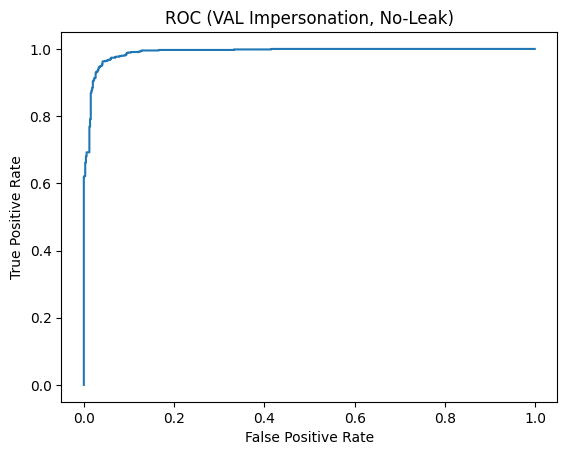

In [ ]:
#REAL IMPERSONATION EVAL (NO LEAK) + THRESHOLDS (FPR FIXED) + ROC/EER
@torch.no_grad()
def precompute_user_means_embed(encoder, X, y, user_set, max_per_user=200):
    encoder.eval()
    means = {}
    for u in user_set:
        idxs = np.where(y == u)[0]
        if len(idxs) == 0:
            continue
        if max_per_user and len(idxs) > max_per_user:
            idxs = np.random.choice(idxs, size=max_per_user, replace=False)
        z = encoder(torch.tensor(X[idxs], dtype=torch.float32, device=device)).mean(dim=0)
        means[int(u)] = z
    return means

def cosine(a, b):
    a = a / (a.norm() + 1e-9)
    b = b / (b.norm() + 1e-9)
    return float((a*b).sum().item())

@torch.no_grad()
def build_impersonation_pairs_no_leak(encoder, X, y, user_set, proto_k=10, per_user=50, hard_mode=True):
    encoder.eval()
    users = [u for u in sorted(list(user_set)) if (y == u).sum() >= (proto_k + per_user)]
    if len(users) < 2:
        raise ValueError("Not enough users with proto_k + per_user samples.")

    means = precompute_user_means_embed(encoder, X, y, user_set) if hard_mode else None

    protos = {}
    X_eval, claimed, y_true = [], [], []

    for A in users:
        idxA = np.where(y == A)[0]
        idxA = np.random.permutation(idxA)

        proto_idx = idxA[:proto_k]
        evalA_idx = idxA[proto_k:proto_k+per_user]

        zA = encoder(torch.tensor(X[proto_idx], dtype=torch.float32, device=device)).mean(dim=0)
        protos[A] = zA

        for i in evalA_idx:
            X_eval.append(X[i]); claimed.append(A); y_true.append(0)

        candidates = [u for u in users if u != A]
        if hard_mode:
            commA = user_id_to_comm.get(A, 0)
            same_comm = [u for u in candidates if user_id_to_comm.get(u, 0) == commA]
            pool = same_comm if len(same_comm) else candidates
            bestB, bestSim = None, -1e9
            for B in pool:
                sim = cosine(means[A], means[B])
                if sim > bestSim:
                    bestSim, bestB = sim, B
            B = bestB
        else:
            B = random.choice(candidates)

        idxB = np.where(y == B)[0]
        chosenB = idxB if len(idxB) <= per_user else np.random.choice(idxB, size=per_user, replace=False)
        for i in chosenB:
            X_eval.append(X[i]); claimed.append(A); y_true.append(1)

    return np.stack(X_eval).astype(np.float32), np.array(claimed), np.array(y_true), protos

@torch.no_grad()
def score_verification(encoder, X_eval, claimed_ids, protos):
    encoder.eval()
    z = encoder(torch.tensor(X_eval, dtype=torch.float32, device=device))
    dists = []
    for i in range(len(X_eval)):
        p = protos[int(claimed_ids[i])].unsqueeze(0)
        dists.append(torch.cdist(z[i:i+1], p).item())
    return np.array(dists, dtype=np.float32)

def compute_roc(y_true, scores):
    thresholds = np.unique(scores)
    P = (y_true == 1).sum()
    N = (y_true == 0).sum()
    fpr, tpr = [], []
    for thr in thresholds:
        pred = (scores > thr).astype(int)
        TP = ((pred==1) & (y_true==1)).sum()
        FP = ((pred==1) & (y_true==0)).sum()
        tpr.append(TP/(P+1e-9))
        fpr.append(FP/(N+1e-9))
    return np.array(fpr), np.array(tpr), thresholds

def find_eer(fpr, tpr, thresholds):
    fnr = 1 - tpr
    idx = np.argmin(np.abs(fpr - fnr))
    eer = float((fpr[idx] + fnr[idx]) / 2)
    return eer, float(thresholds[idx])

# FPR FIX: choose smallest threshold satisfying FPR constraint
def threshold_by_fpr(y_true, scores, target_fpr=0.02):
    fpr, tpr, thr = compute_roc(y_true, scores)
    ok = np.where(fpr <= target_fpr)[0]
    if len(ok) == 0:
        return float(np.max(thr))
    return float(thr[ok[0]])

def threshold_best_f1(y_true, scores):
    thresholds = np.unique(scores)
    best_f1, best_thr = -1, None
    for thr in thresholds:
        pred = (scores > thr).astype(int)
        TP = ((pred==1) & (y_true==1)).sum()
        FP = ((pred==1) & (y_true==0)).sum()
        FN = ((pred==0) & (y_true==1)).sum()
        prec = TP/(TP+FP+1e-9)
        rec  = TP/(TP+FN+1e-9)
        f1 = 2*prec*rec/(prec+rec+1e-9)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
    return float(best_thr), float(best_f1)

def report_metrics(y_true, scores, thr, title=""):
    pred = (scores > thr).astype(int)
    print("\n"+title)
    print("Threshold:", thr)
    print("Confusion matrix:\n", confusion_matrix(y_true, pred))
    print(classification_report(y_true, pred, digits=4, zero_division=0))

# --- CALIBRATE ON VAL (NO LEAK) ---
print("\nCalibrating on VAL (HARD, NO-LEAK)...")
X_val_imp, claimed_val, y_val_imp, protos_val = build_impersonation_pairs_no_leak(
    encoder, X, y, val_u, proto_k=10, per_user=50, hard_mode=True
)
scores_val = score_verification(encoder, X_val_imp, claimed_val, protos_val)

thr_fpr = threshold_by_fpr(y_val_imp, scores_val, TARGET_FPR)
thr_f1, best_f1 = threshold_best_f1(y_val_imp, scores_val)

fpr, tpr, thrs = compute_roc(y_val_imp, scores_val)
eer, eer_thr = find_eer(fpr, tpr, thrs)

print(f"VAL thr@FPR<={TARGET_FPR:.3f}: {thr_fpr:.4f}")
print(f"VAL thr_bestF1: {thr_f1:.4f} (F1={best_f1:.4f})")
print(f"VAL EER: {eer:.4f} at thr={eer_thr:.4f}")

report_metrics(y_val_imp, scores_val, thr_fpr, "VAL @ FPR threshold")
report_metrics(y_val_imp, scores_val, thr_f1,  "VAL @ BestF1 threshold")

# --- TEST IMPERSONATION (NO LEAK) ---
print("\nTesting on TEST (HARD, NO-LEAK)...")
X_test_imp, claimed_test, y_test_imp, protos_test = build_impersonation_pairs_no_leak(
    encoder, X, y, test_u, proto_k=10, per_user=50, hard_mode=True
)
scores_test = score_verification(encoder, X_test_imp, claimed_test, protos_test)

report_metrics(y_test_imp, scores_test, thr_fpr, "TEST @ FPR threshold")
report_metrics(y_test_imp, scores_test, thr_f1,  "TEST @ BestF1 threshold")

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (VAL Impersonation, No-Leak)")
plt.show()
scores_test = score_verification(encoder, X_test_imp, claimed_test, protos_test)


In [ ]:
#Print SOC Report During Evaluation
def print_soc_report_example(title, idx, X_eval, claimed_ids, scores, y_true, protos, encoder, threshold):
    claimed_uid = int(claimed_ids[idx])
    dist = float(scores[idx])

    # best effort: find a df row for context (user + some recipients)
    claimed_email = caches["id2user"][claimed_uid]
    df_row = df[df["user"] == claimed_email].iloc[0]
    recipients = [r.strip() for r in str(df_row["recipients"]).split(";") if r.strip()]
    sent_dt = pd.to_datetime(df_row["date"])

    rep = soc_forensic_report(
        claimed_uid=claimed_uid,
        sender_email=claimed_email,
        recipients=recipients,
        sent_dt=sent_dt,
        distance=dist,
        threshold=threshold,
        x_scaled=X_eval[idx],
        baselines=soc_baselines
    )

    print("\n" + "="*80)
    print(title)
    print(f"Claimed user: {claimed_email}")
    print(json.dumps(rep, indent=2))
    print("="*80)

# After you have: X_test_imp, claimed_test, y_test_imp, scores_test, thr_f1
# Print one genuine (0) and one impostor (1)
g_idx = int(np.where(y_test_imp == 0)[0][0])
i_idx = int(np.where(y_test_imp == 1)[0][0])

print_soc_report_example("SOC REPORT (GENUINE SAMPLE)", g_idx, X_test_imp, claimed_test, scores_test, y_test_imp,
                         protos_test, encoder, threshold=thr_f1)

print_soc_report_example("SOC REPORT (IMPOSTOR SAMPLE)", i_idx, X_test_imp, claimed_test, scores_test, y_test_imp,
                         protos_test, encoder, threshold=thr_f1)



SOC REPORT (GENUINE SAMPLE)
Claimed user: james.steffes@enron.com
{
  "decision": "CLEAN",
  "risk": "UNKNOWN_BASELINE",
  "distance": 0.5595613718032837,
  "threshold": 2.264551877975464,
  "summary": [
    "No baseline available for claimed user (not enough history)."
  ]
}

SOC REPORT (IMPOSTOR SAMPLE)
Claimed user: james.steffes@enron.com
{
  "decision": "FLAGGED",
  "risk": "UNKNOWN_BASELINE",
  "distance": 12.179229736328125,
  "threshold": 2.264551877975464,
  "summary": [
    "No baseline available for claimed user (not enough history)."
  ]
}


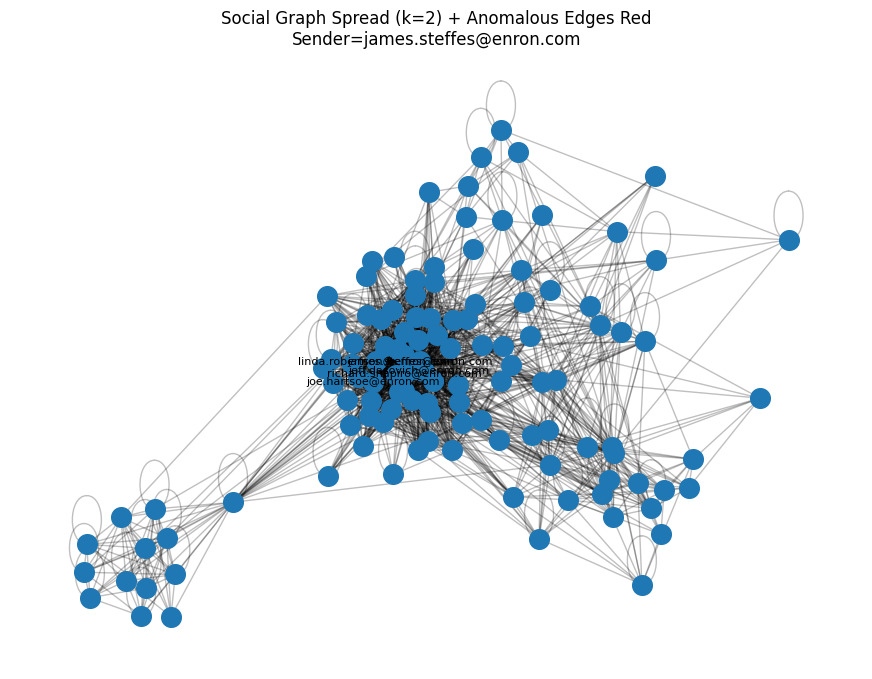

In [ ]:
from collections import defaultdict

def compute_edge_counts(df):
    counts = defaultdict(int)
    totals = defaultdict(int)
    for _, row in df.iterrows():
        s = row["user"]
        recips = [r.strip() for r in str(row["recipients"]).split(";") if r.strip()]
        for r in recips:
            counts[(s, r)] += 1
            totals[s] += 1
    return counts, totals

# Build edge frequency model once (needed for anomaly coloring)
edge_counts, sender_totals = compute_edge_counts(df)

def is_anomalous_edge(sender, recipient, min_count=2, min_prob=0.01):
    c = edge_counts.get((sender, recipient), 0)
    tot = sender_totals.get(sender, 0)
    p = c / tot if tot > 0 else 0.0
    return (c < min_count) or (p < min_prob)

def plot_social_graph_anomaly(G, sender_email, current_recipients, k_hops=2, max_nodes=120):
    import matplotlib.pyplot as plt
    import networkx as nx

    if sender_email not in G:
        print("Sender not in graph.")
        return

    H = nx.ego_graph(G.to_undirected(), sender_email, radius=k_hops)

    # Limit size for readability
    if H.number_of_nodes() > max_nodes:
        deg = sorted(H.degree, key=lambda x: x[1], reverse=True)[:max_nodes]
        keep = {n for n,_ in deg}
        H = H.subgraph(keep).copy()

    pos = nx.spring_layout(H, seed=42)

    plt.figure(figsize=(11, 8))
    nx.draw_networkx_nodes(H, pos, node_size=200)
    nx.draw_networkx_edges(H, pos, alpha=0.25)

    # Highlight the recipient edges: red if anomalous
    for r in current_recipients:
        if r in H:
            anom = is_anomalous_edge(sender_email, r)
            if H.has_edge(sender_email, r):
                edge = (sender_email, r)
            else:
                edge = (r, sender_email)

            nx.draw_networkx_edges(
                H, pos,
                edgelist=[edge],
                width=3.0 if anom else 2.0,
                edge_color="red" if anom else "black",
                alpha=0.9
            )

    # Labels (keep minimal)
    labels = {sender_email: sender_email}
    for r in current_recipients[:10]:
        if r in H:
            labels[r] = r
    nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)

    plt.title(f"Social Graph Spread (k={k_hops}) + Anomalous Edges Red\nSender={sender_email}")
    plt.axis("off")
    plt.show()
    claimed_uid = int(claimed_test[i_idx])
claimed_email = caches["id2user"][claimed_uid]
df_row = df[df["user"] == claimed_email].iloc[0]
recipients = [r.strip() for r in str(df_row["recipients"]).split(";") if r.strip()]

plot_social_graph_anomaly(caches["graph"], claimed_email, recipients, k_hops=2)



In [ ]:
#ABLATION (Stylometry vs Behavioral vs Hybrid)
def mask_features_keep(X_in, keep_idx):
    X2 = X_in.copy()
    drop = [i for i in range(X2.shape[1]) if i not in keep_idx]
    X2[:, drop] = 0.0
    return X2

def quick_train_and_test(X_use, seed=42, tag=""):
    set_seed(seed)
    tr_u, va_u, te_u = split_users(y, 0.70, 0.15, seed=seed)

    trS = HardEpisodeSampler(X_use, y, tr_u, N_WAY, K_SHOT, Q_QUERY)
    vaS = HardEpisodeSampler(X_use, y, va_u, N_WAY, K_SHOT, Q_QUERY)
    teS = HardEpisodeSampler(X_use, y, te_u, N_WAY, K_SHOT, Q_QUERY)

    enc = MLPEncoder(INPUT_DIM, EMBED_DIM, HIDDEN_DIMS, DROPOUT).to(device)
    opt = torch.optim.Adam(enc.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    best = -1
    best_state = None
    for _ in range(META_EPOCHS):
        run_episodes(enc, trS, opt, episodes=TRAIN_EPISODES//META_EPOCHS, train=True)
        _, va_acc = run_episodes(enc, vaS, None, episodes=VAL_EPISODES//META_EPOCHS, train=False)
        if va_acc > best:
            best = va_acc
            best_state = {k:v.detach().cpu().clone() for k,v in enc.state_dict().items()}
    enc.load_state_dict(best_state)

    # calibration
    Xv, cv, yv, pv = build_impersonation_pairs_no_leak(enc, X_use, y, va_u, proto_k=10, per_user=30, hard_mode=True)
    sv = score_verification(enc, Xv, cv, pv)
    thr, _ = threshold_best_f1(yv, sv)

    # test
    Xt, ct, yt, pt = build_impersonation_pairs_no_leak(enc, X_use, y, te_u, proto_k=10, per_user=30, hard_mode=True)
    st = score_verification(enc, Xt, ct, pt)
    pred = (st > thr).astype(int)
    acc = (pred == yt).mean()

    return {"mode": tag, "imp_acc": float(acc)}

ablation = []
ablation.append(quick_train_and_test(mask_features_keep(X, IDX_STYLE), seed=42, tag="Stylometry Only"))
ablation.append(quick_train_and_test(mask_features_keep(X, IDX_TEMP+IDX_SOC), seed=42, tag="Behavioral Only"))
ablation.append(quick_train_and_test(X, seed=42, tag="Hybrid (All 26)"))

pd.DataFrame(ablation)


,mode,imp_acc
0,Stylometry Only,0.541176
1,Behavioral Only,0.943137
2,Hybrid (All 26),0.907843


In [ ]:
#5-RUN ROBUSTNESS (mean ± std)
seeds = [11, 22, 33, 44, 55]
accs = []
for s in seeds:
    res = quick_train_and_test(X, seed=s, tag="Hybrid")
    accs.append(res["imp_acc"])
    print("seed", s, "impersonation acc", res["imp_acc"])

mean_acc = np.mean(accs)
std_acc = np.std(accs, ddof=1)
print(f"\nHybrid impersonation accuracy = {mean_acc*100:.2f}% ± {std_acc*100:.2f}% (5 runs)")



seed 11 impersonation acc 0.8591666666666666


seed 22 impersonation acc 0.9138888888888889


seed 33 impersonation acc 0.9916666666666667


seed 44 impersonation acc 0.9568627450980393


seed 55 impersonation acc 0.9515873015873015

Hybrid impersonation accuracy = 93.46% ± 5.04% (5 runs)


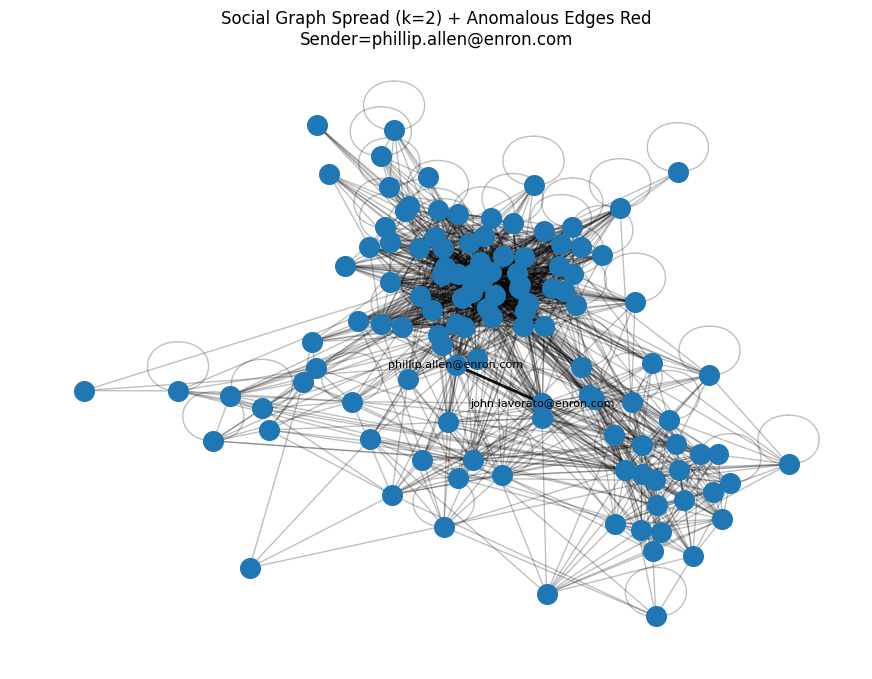

In [ ]:
#XAI + Social Graph Spread
def compute_edge_counts(df):
    counts = defaultdict(int)
    totals = defaultdict(int)
    for _, row in df.iterrows():
        s = row["user"]
        recips = [r.strip() for r in str(row["recipients"]).split(";") if r.strip()]
        for r in recips:
            counts[(s, r)] += 1
            totals[s] += 1
    return counts, totals

edge_counts, sender_totals = compute_edge_counts(df)

def is_anomalous_edge(sender, recipient, min_count=2, min_prob=0.01):
    c = edge_counts.get((sender, recipient), 0)
    tot = sender_totals.get(sender, 0)
    p = c/tot if tot>0 else 0
    return (c < min_count) or (p < min_prob)


def plot_social_graph_anomaly(G, sender_email, current_recipients, k_hops=2, max_nodes=120):
    if sender_email not in G:
        print("Sender not in graph.")
        return
    H = nx.ego_graph(G.to_undirected(), sender_email, radius=k_hops)
    if H.number_of_nodes() > max_nodes:
        deg = sorted(H.degree, key=lambda x: x[1], reverse=True)[:max_nodes]
        keep = {n for n,_ in deg}
        H = H.subgraph(keep).copy()
    pos = nx.spring_layout(H, seed=42)

    plt.figure(figsize=(11, 8))
    nx.draw_networkx_nodes(H, pos, node_size=200)
    nx.draw_networkx_edges(H, pos, alpha=0.25)

    for r in current_recipients:
        if r in H:
            anom = is_anomalous_edge(sender_email, r)
            edge = (sender_email, r) if H.has_edge(sender_email, r) else (r, sender_email)
            nx.draw_networkx_edges(H, pos, edgelist=[edge],
                                   width=3.0 if anom else 2.0,
                                   edge_color="red" if anom else "black",
                                   alpha=0.9)
    labels = {sender_email: sender_email}
    for r in current_recipients[:10]:
        if r in H: labels[r] = r
    nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)
    plt.title(f"Social Graph Spread (k={k_hops}) + Anomalous Edges Red\nSender={sender_email}")
    plt.axis("off")
    plt.show()

# Demo plot
row = df.iloc[0]
sender = row["user"]
recips = [r.strip() for r in str(row["recipients"]).split(";") if r.strip()]
plot_social_graph_anomaly(caches["graph"], sender, recips, k_hops=2)